# Pole Balancing

In [3]:
#Importing Libraries
import random
import gym
import numpy as np
import logging
import os
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


## Definition of Functions

In [4]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning
    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                # a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
                # target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

def switch_k_backend_device():
    #import logging
    #import keras.backend as K
    #import os
    """ Switches `keras` backend from GPU to CPU if required.

    Faster computation on CPU (if using tensorflow-gpu).
    """
    if K.backend() == 'tensorflow':
        logging.debug('switching to TensorFlow for CPU')
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Training of Agent

In [12]:
EPISODES =200
# Training of model
K.clear_session()
switch_k_backend_device()  # Train on CPU instead of GPU (CPU is faster with this model)
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# agent.load("./save/cartpole-ddqn.h5")
done = False
agent = Agent(state_size, action_size)
batch_size = 32

score_hist = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        #env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e+1, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        score_hist.append(time)
        if time > 475:
            sname = "mod2_" + str(e)
            agent.save(sname)

episode: 1/200, score: 12, e: 1.0
episode: 2/200, score: 11, e: 1.0
episode: 3/200, score: 15, e: 0.92
episode: 4/200, score: 17, e: 0.78
episode: 5/200, score: 11, e: 0.7
episode: 6/200, score: 13, e: 0.61
episode: 7/200, score: 9, e: 0.56
episode: 8/200, score: 22, e: 0.45
episode: 9/200, score: 9, e: 0.41
episode: 10/200, score: 9, e: 0.37
episode: 11/200, score: 14, e: 0.32
episode: 12/200, score: 12, e: 0.29
episode: 13/200, score: 15, e: 0.25
episode: 14/200, score: 13, e: 0.22
episode: 15/200, score: 14, e: 0.19
episode: 16/200, score: 13, e: 0.17
episode: 17/200, score: 21, e: 0.13
episode: 18/200, score: 17, e: 0.11
episode: 19/200, score: 48, e: 0.07
episode: 20/200, score: 20, e: 0.057
episode: 21/200, score: 13, e: 0.05
episode: 22/200, score: 24, e: 0.039
episode: 23/200, score: 26, e: 0.03
episode: 24/200, score: 29, e: 0.023
episode: 25/200, score: 27, e: 0.017
episode: 26/200, score: 30, e: 0.013
episode: 27/200, score: 53, e: 0.0099
episode: 28/200, score: 45, e: 0.009

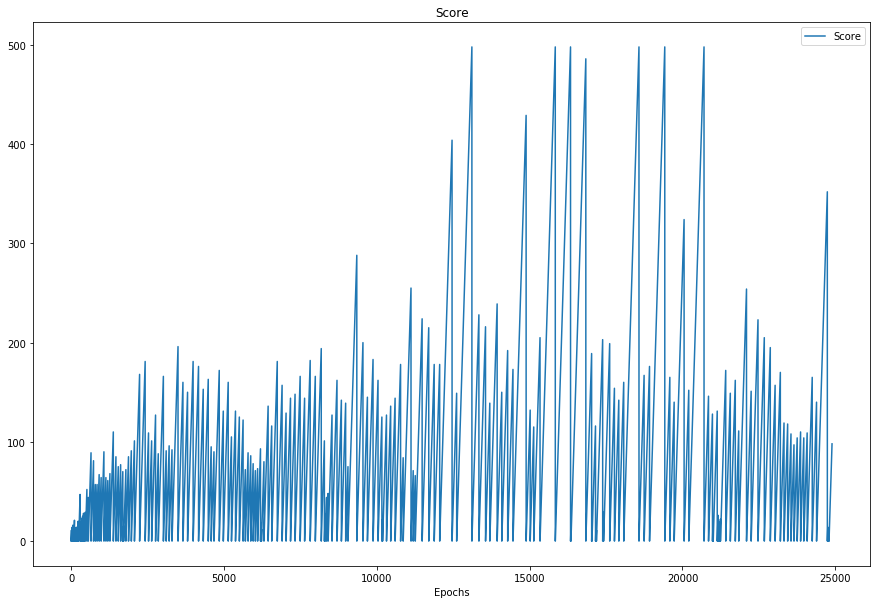

In [13]:
#Plotting Learning History
plt.figure(figsize = (15,10))
plt.plot(score_hist, label = "Score")
plt.title("Score")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Test incl. Animation

In [16]:
#env = gym.make('CartPole-v1')
env.reset()
agent.load("mod2_139")

for time in range(1000):
    env.render()
    
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)

    next_state = np.reshape(next_state, [1, state_size])

    state = next_state
    if done:
         break